In [2]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
from mlxtend.plotting import plot_confusion_matrix
import warnings
from scipy.signal import savgol_filter, find_peaks, correlate
from sklearn.decomposition import PCA
import scipy.fftpack as FFT
from sklearn.utils import shuffle
import joblib
import scipy.stats as stats
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = [12,5]

In [3]:
def sampling_freq(df):
    start = df['time'].iloc[0]
    sum_samples = 0
    index = 0
    while  (start + pd.to_timedelta(1, unit='s')) < df['time'].iloc[-1]:
        end =  start + pd.to_timedelta(1, unit='s')
        sum_samples += df[(df['time'] >= start) & (df['time'] < end)].shape[0]
        start += pd.to_timedelta(1, unit='s')
        index += 1
    return sum_samples/index

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

def convert_to_datetime(x):
    dt = datetime.fromtimestamp(x // 1000000000)
    s = dt.strftime('%Y-%m-%d %H:%M:%S')
    s += '.' + str(int(x % 1000000000)).zfill(9)
    return s

def heatmap(cm, labels):
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)

    plt.show()
    
def preprocess(data, activity, drop_interval_begin = 3, drop_interval_end = 3):
    #convert nanoseconds to date 
    data['time'] = data['time'].apply(convert_to_datetime) 
    data['time'] = pd.to_datetime(data['time'])

#convert to same data type
    for i in range(1, 4): 
        data[column_names_org[i]] = data[column_names_org[i]].apply(convert_to_float)
    
#drop rows with NaN values 
    data.dropna(axis=0, how='any', inplace=True) #TODO: invullen met mean, mod of median / interpolatie

#drop duplicates 
    data.drop_duplicates(subset=None, keep='first', inplace = True)
    
    #drop first and last 3 sec
    indexFirst = data[ (data['time'].iloc[0]+ pd.to_timedelta(drop_interval_begin, unit='s')) > data['time'] ].index
    data.drop(indexFirst , inplace=True)
    indexLast = data[ (data['time'].iloc[-1]- pd.to_timedelta(drop_interval_end, unit='s')) < data['time'] ].index
    data.drop(indexLast , inplace=True)
    
    #add activity label
    data['activity'] = activity
    
    return data

#TODO: verschillende activiteiten in 1 frame
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
       
        # Retrieve the most often used label in this segment
        label = stats.mode(df['activity'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

   #print("ORG:",frames)
    # Bring the segments into a better shape
    frames = np.asarray(frames)#.reshape(-1, frame_size, N_FEATURES)
    print("NEW:",frames)
    labels = np.asarray(labels)

    return frames, labels

def windows(data, size):
    start = 0
    while start < data.count():
        yield start, start + size
        start += (size / 2)
        
def segment_signal(data,window_size, overlap):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data["time"], window_size):
        start = int(start)
        end = int(end)
        x = data["x"][start:end]
        y = data["y"][start:end]
        z = data["z"][start:end]
        if(len(data["time"][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["activity"][start:end])[0][0])
    return segments, labels

In [4]:
column_names_org = ['time', 'x', 'y', 'z']
moves = ["jump_fast", "jump_slow", "side_swing", "cross_over", "forward_180"]
moves_df = {}

# PREPROCESSING

## jump fast

In [5]:
jump_fast_files = ["jump_fast.csv", "jump_fast (meting2).csv"]
jump_fast_df = []

In [6]:
for f in jump_fast_files:
    jump_fast = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_fast\proefpersoon2\\" + f, sep=';', header=0, skipinitialspace=True)
    jump_fast = preprocess(jump_fast, "jump_fast")
    jump_fast_df.append(jump_fast)

In [7]:
#preserve raw data
jump_fast_raw =  pd.concat(jump_fast_df, ignore_index=True)
moves_df["jump_fast"] = jump_fast_raw
jump_fast_raw.head()

,time,x,y,z,activity
0,1970-01-01 01:23:31.161128960,-13.727624,-5.393422,10.435100,jump_fast
1,1970-01-01 01:23:31.179347968,-14.868999,-8.697910,10.521241,jump_fast
2,1970-01-01 01:23:31.198877696,-17.388641,-6.417551,2.141576,jump_fast
3,1970-01-01 01:23:31.218669568,-28.742586,-34.614571,9.489935,jump_fast
4,1970-01-01 01:23:31.237543936,-12.117254,-13.351951,8.276773,jump_fast


In [8]:
freq = {}

In [9]:
freq["jump_fast"] = 0
for df in jump_fast_df:
    f = sampling_freq(df)
    freq["jump_fast"] += f
freq["jump_fast"] /= len(jump_fast_df)
freq

{'jump_fast': 51.828947368421055}

## jump slow

In [10]:
jump_slow_files = ["jump_slow.csv", "jump_slow1 (meting2).csv"]
jump_slow_df = []

In [11]:
for f in jump_slow_files:
    d = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\jump_slow\proefpersoon2\\" + f, sep=';', header=0, skipinitialspace=True)
    d = preprocess(d, "jump_slow")
    jump_slow_df.append(d)

In [12]:
#preserve raw data
jump_slow_raw =  pd.concat(jump_slow_df, ignore_index=True)
moves_df["jump_slow"] = jump_slow_raw
jump_slow_raw.head()

,time,x,y,z,activity
0,1970-01-01 01:22:43.384205312,5.812166,-7.269395,-5.000999,jump_slow
1,1970-01-01 01:22:43.403997184,-1.052842,-5.434100,-2.892923,jump_slow
2,1970-01-01 01:22:43.422347264,-4.833502,-8.195417,-3.342773,jump_slow
3,1970-01-01 01:22:43.442663424,-8.176275,-9.966106,-6.037092,jump_slow
4,1970-01-01 01:22:43.461931008,-7.305287,-7.922636,-9.257831,jump_slow


In [13]:
freq["jump_slow"] = 0
for df in jump_slow_df:
    f = sampling_freq(df)
    freq["jump_slow"] += f
freq["jump_slow"] /= len(jump_slow_df)
freq

{'jump_fast': 51.828947368421055, 'jump_slow': 51.85828877005348}

## side swing

In [14]:
side_swing_files = ["side_swing.csv", "side_swing2 (meting2).csv", "side_swing3 (meting2).csv"]
side_swing_df = []

In [15]:
for f in side_swing_files:
    d = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\side_swing\proefpersoon2\\" + f, sep=';', header=0, skipinitialspace=True)
    d = preprocess(d, "side_swing")
    side_swing_df.append(d)

In [16]:
#preserve raw data
side_swing_raw =  pd.concat(side_swing_df, ignore_index=True)
moves_df["side_swing"] = side_swing_raw
side_swing_raw.head()

,time,x,y,z,activity
0,1970-01-01 04:25:01.846446080,-4.242475,-8.889337,2.167897,side_swing
1,1970-01-01 04:25:01.859028992,-4.242475,-8.889337,2.167897,side_swing
2,1970-01-01 04:25:01.871611904,-5.032106,-9.166903,3.656233,side_swing
3,1970-01-01 04:25:01.887340544,-4.862216,-9.195618,5.790631,side_swing
4,1970-01-01 04:25:01.911457792,-4.972285,-10.100104,5.395815,side_swing


In [17]:
freq["side_swing"] = 0
for df in side_swing_df:
    f = sampling_freq(df)
    freq["side_swing"] += f
freq["side_swing"] /= len(side_swing_df)
freq

{'jump_fast': 51.828947368421055,
 'jump_slow': 51.85828877005348,
 'side_swing': 52.17316017316017}

## cross over

In [18]:
cross_over_files = ["cross_over2.csv", "cross_over3.csv", "cross_over4.csv", "cross_over5.csv"]
cross_over_df = []

In [19]:
for f in cross_over_files:
    d = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\cross_over\proefpersoon2\\" + f, sep=';', header=0, skipinitialspace=True)
    d = preprocess(d, "cross_over")
    cross_over_df.append(d)

In [20]:
#preserve raw data
cross_over_raw =  pd.concat(cross_over_df, ignore_index=True)
moves_df["cross_over"] = cross_over_raw
cross_over_raw.head()

,time,x,y,z,activity
0,1970-01-01 11:20:00.582410240,-2.160719,-6.233303,-14.897714,cross_over
1,1970-01-01 11:20:00.599187456,-3.905087,-10.815558,-13.521841,cross_over
2,1970-01-01 11:20:00.620158976,-6.647261,-13.981263,-12.650853,cross_over
3,1970-01-01 11:20:00.641130496,-10.040284,-15.531812,-11.734403,cross_over
4,1970-01-01 11:20:00.657907712,-7.441679,-21.116659,-14.184652,cross_over


In [21]:
freq["cross_over"] = 0
for df in cross_over_df:
    f = sampling_freq(df)
    freq["cross_over"] += f
freq["cross_over"] /= len(cross_over_df)
freq

{'jump_fast': 51.828947368421055,
 'jump_slow': 51.85828877005348,
 'side_swing': 52.17316017316017,
 'cross_over': 52.37883116883117}

## forward 180

In [22]:
forward_180_files = ["forward_180_2.csv"]
forward_180_df = []

In [23]:
for f in forward_180_files:
    d = pd.read_csv(r"C:\Users\Elise\Documents\unif\master\semester2\masterproef\gitProject\thesis\data\forward_180\proefpersoon2\\" + f, sep=';', header=0, skipinitialspace=True)
    d = preprocess(d, "forward_180")
    forward_180_df.append(d)

In [24]:
#preserve raw data
forward_180_raw = pd.concat(forward_180_df, ignore_index=True)
moves_df["forward_180"] = forward_180_raw
forward_180_raw.head()

,time,x,y,z,activity
0,1970-01-01 11:32:59.263336448,-18.680767,-12.942778,5.675776,forward_180
1,1970-01-01 11:32:59.284307968,-16.331015,-10.521241,5.505885,forward_180
2,1970-01-01 11:32:59.305279488,-17.601603,-3.617948,5.479564,forward_180
3,1970-01-01 11:32:59.322056704,-18.474983,-5.826523,7.613962,forward_180
4,1970-01-01 11:32:59.343028224,-16.907684,-7.776674,8.197810,forward_180


In [25]:
freq["forward_180"] = 0
for df in forward_180_df:
    f = sampling_freq(df)
    freq["forward_180"] += f
freq["forward_180"] /= len(forward_180_df)
freq

{'jump_fast': 51.828947368421055,
 'jump_slow': 51.85828877005348,
 'side_swing': 52.17316017316017,
 'cross_over': 52.37883116883117,
 'forward_180': 51.81666666666667}

# CLASSIFICATION

## shuffle - balance data

In [26]:
shape = np.min([jump_fast_raw.shape[0], jump_slow_raw.shape[0], side_swing_raw.shape[0], cross_over_raw.shape[0], forward_180_raw.shape[0]])
jump_fast_raw = shuffle(jump_fast_raw).head(shape).copy()
jump_slow_raw = shuffle(jump_slow_raw).head(shape).copy()
side_swing_raw = shuffle(side_swing_raw).head(shape).copy()
cross_over_raw = shuffle(cross_over_raw).head(shape).copy()
forward_180_raw = shuffle(forward_180_raw).head(shape).copy()
moves_df["jump_fast"] = jump_fast_raw
moves_df["jump_slow"] = jump_slow_raw
moves_df["side_swing"] = side_swing_raw
moves_df["cross_over"] = cross_over_raw
moves_df["forward_180"] = forward_180_raw
shape

2939

## merge activities

In [27]:
merged_raw = pd.concat([jump_fast_raw, jump_slow_raw, side_swing_raw, cross_over_raw, forward_180_raw], ignore_index=True) 
target = merged_raw['activity']
merged_raw

,time,x,y,z,activity
0,1970-01-01 01:24:00.618250240,-2.222932,-14.797215,5.309673,jump_fast
1,1970-01-01 04:38:30.995845120,0.155533,-13.258630,-10.102497,jump_fast
2,1970-01-01 04:38:27.154911232,-25.009783,-14.833108,4.285545,jump_fast
3,1970-01-01 01:23:38.703798272,-16.780865,-9.911072,15.505490,jump_fast
4,1970-01-01 04:38:39.393890304,-16.639688,-13.914264,12.815958,jump_fast
...,...,...,...,...,...
14690,1970-01-01 11:34:26.903318528,-0.476172,-5.986842,-1.883151,forward_180
14691,1970-01-01 11:33:20.947888128,-19.678574,-4.984250,-3.254239,forward_180
14692,1970-01-01 11:34:36.336308224,-5.149354,-14.301901,-0.705883,forward_180
14693,1970-01-01 11:34:34.159464448,-2.919244,-13.182060,-5.826523,forward_180


## labeling

In [28]:
#label activity
le = preprocessing.LabelEncoder()
le.fit(merged_raw['activity'])
merged_raw['activity'] = le.transform(merged_raw['activity'])
label = le.inverse_transform([0,1,2,3,4])
label

array(['cross_over', 'forward_180', 'jump_fast', 'jump_slow',
       'side_swing'], dtype=object)

## normalize

In [29]:
Normalizer = preprocessing.Normalizer().fit(merged_raw[['x', 'y', 'z']])
merged_raw[['x', 'y', 'z']] = Normalizer.transform(merged_raw[['x', 'y', 'z']])
merged_raw.head()

,time,x,y,z,activity
0,1970-01-01 01:24:00.618250240,-0.140006,-0.931968,0.334417,2
1,1970-01-01 04:38:30.995845120,0.009330,-0.795377,-0.606043,2
2,1970-01-01 04:38:27.154911232,-0.850911,-0.504669,0.145808,2
3,1970-01-01 01:23:38.703798272,-0.673802,-0.397959,0.622591,2
4,1970-01-01 04:38:39.393890304,-0.660464,-0.552286,0.508692,2


## segmentation

In [31]:
samp_freq=sum(freq.values())/len(freq)
samp_freq

52.01117882942651

In [32]:
segments, labels = segment_signal(merged_raw, int(samp_freq), False)
#ONE HOT ENCODING
#labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
#reshaped_segments = segments.reshape(len(segments),len(segments[0]), len(segments[0][0]), 1 )

#### 2D model

In [31]:
#segments = segments.reshape(len(segments),len(segments[0]), len(segments[0][0]), 1 )

In [33]:
segments.shape, labels.shape

((564, 52, 3), (564,))

## neural network

https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

In [33]:
X = segments
Y = labels
X.shape, Y.shape

((564, 52, 3), (564,))

In [34]:
X_train, X_test, y_train, y_test_1 = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
X_train.shape, y_test_1.shape

((451, 52, 3), (113,))

In [35]:
y_train = np.asarray(pd.get_dummies(y_train), dtype = np.int8)
y_test = np.asarray(pd.get_dummies(y_test_1), dtype = np.int8)
y_train.shape, y_test.shape

((451, 5), (113, 5))

In [36]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [37]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [38]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
epo = 200
history = model.fit(X_train, y_train, epochs = epo, batch_size=32, validation_data= (X_test, y_test), verbose=1, shuffle=True) 

Train on 451 samples, validate on 113 samples
Epoch 1/200
451/451 [==============================] - 2s 5ms/sample - loss: 1.3145 - accuracy: 0.5144 - val_loss: 0.9496 - val_accuracy: 0.7611
Epoch 2/200
451/451 [==============================] - 0s 793us/sample - loss: 0.6228 - accuracy: 0.8093 - val_loss: 0.5195 - val_accuracy: 0.7965
Epoch 3/200
451/451 [==============================] - 0s 778us/sample - loss: 0.3565 - accuracy: 0.8404 - val_loss: 0.4212 - val_accuracy: 0.7965
Epoch 4/200
451/451 [==============================] - 0s 835us/sample - loss: 0.2676 - accuracy: 0.8869 - val_loss: 0.2857 - val_accuracy: 0.9027
Epoch 5/200
451/451 [==============================] - 0s 1ms/sample - loss: 0.2079 - accuracy: 0.9290 - val_loss: 0.2696 - val_accuracy: 0.9115
Epoch 6/200
451/451 [==============================] - 0s 851us/sample - loss: 0.2047 - accuracy: 0.9135 - val_loss: 0.2898 - val_accuracy: 0.8850
Epoch 7/200
451/451 [==============================] - 0s 591us/sample - los

451/451 [==============================] - 1s 2ms/sample - loss: 5.1250e-04 - accuracy: 1.0000 - val_loss: 0.0592 - val_accuracy: 0.9558
Epoch 110/200
451/451 [==============================] - 1s 1ms/sample - loss: 2.8592e-04 - accuracy: 1.0000 - val_loss: 0.0713 - val_accuracy: 0.9735
Epoch 111/200
451/451 [==============================] - 1s 1ms/sample - loss: 3.9328e-04 - accuracy: 1.0000 - val_loss: 0.0438 - val_accuracy: 0.9735TA: 0s - loss: 4.8844e-04 - accu
Epoch 112/200
451/451 [==============================] - 0s 590us/sample - loss: 2.2961e-04 - accuracy: 1.0000 - val_loss: 0.0447 - val_accuracy: 0.9735
Epoch 113/200
451/451 [==============================] - 0s 522us/sample - loss: 3.1450e-04 - accuracy: 1.0000 - val_loss: 0.0442 - val_accuracy: 0.9735
Epoch 114/200
451/451 [==============================] - 0s 531us/sample - loss: 1.9762e-04 - accuracy: 1.0000 - val_loss: 0.0454 - val_accuracy: 0.9823
Epoch 115/200
451/451 [==============================] - 0s 668us/samp

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 64)            640       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 64)            12352     
_________________________________________________________________
dropout (Dropout)            (None, 48, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               153700    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5

In [42]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

<IPython.core.display.Javascript object>


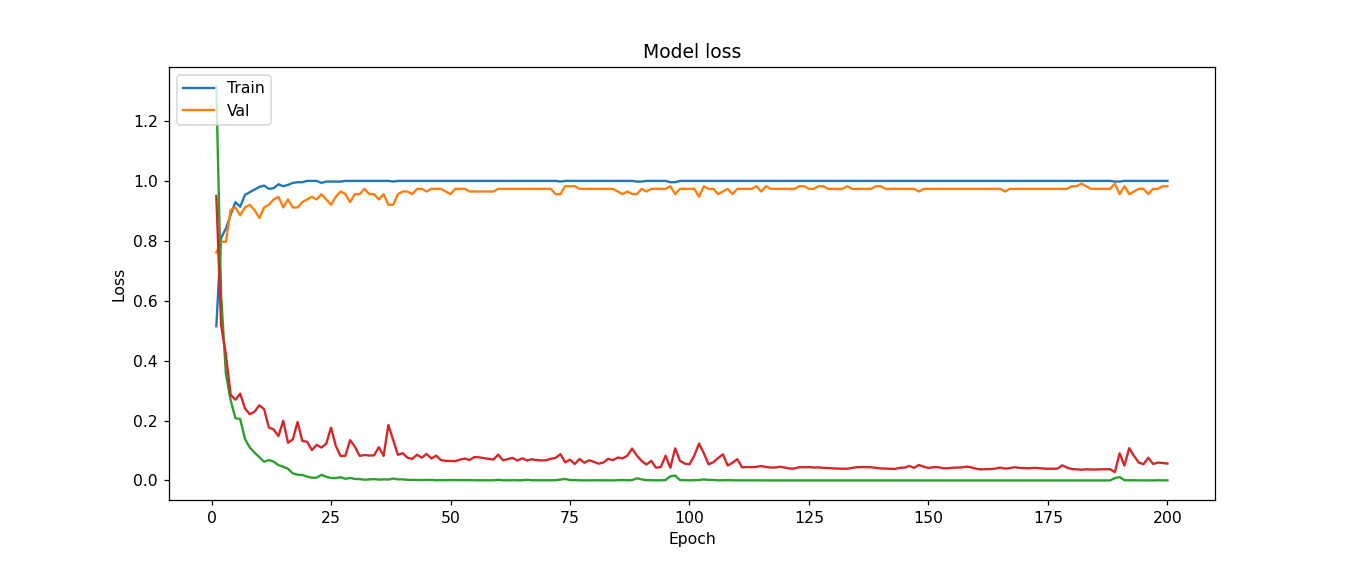

In [43]:
plt.figure()
plot_learningCurve(history, epo)

In [44]:
y_proba = model.predict_proba(X_test)*100
y_proba[0]

array([7.7573037e-05, 1.3418449e-17, 2.6546656e-03, 8.8453726e-06,
       9.9997246e+01], dtype=float32)

In [45]:
y_pred = model.predict_classes(X_test)
print(X_test.shape)
y_pred

(113, 52, 3)


array([4, 1, 1, 3, 2, 4, 1, 3, 4, 4, 3, 3, 1, 2, 0, 4, 2, 4, 2, 2, 0, 3,
       0, 0, 0, 1, 4, 2, 1, 1, 4, 2, 4, 0, 0, 3, 0, 1, 1, 0, 0, 3, 1, 1,
       1, 2, 1, 2, 2, 3, 3, 1, 2, 1, 4, 1, 1, 3, 0, 3, 2, 0, 2, 2, 3, 3,
       4, 4, 4, 3, 0, 2, 1, 2, 0, 0, 2, 2, 2, 0, 4, 3, 4, 3, 4, 4, 1, 0,
       3, 4, 4, 2, 3, 3, 3, 4, 3, 2, 0, 2, 1, 4, 4, 2, 0, 4, 2, 1, 3, 0,
       3, 0, 0], dtype=int64)

(113,) (113,)
113/113 [==============================] - 0s 274us/sample - loss: 0.0563 - accuracy: 0.9823
test loss, test acc: [0.05629364422942817, 0.9823009]


<IPython.core.display.Javascript object>


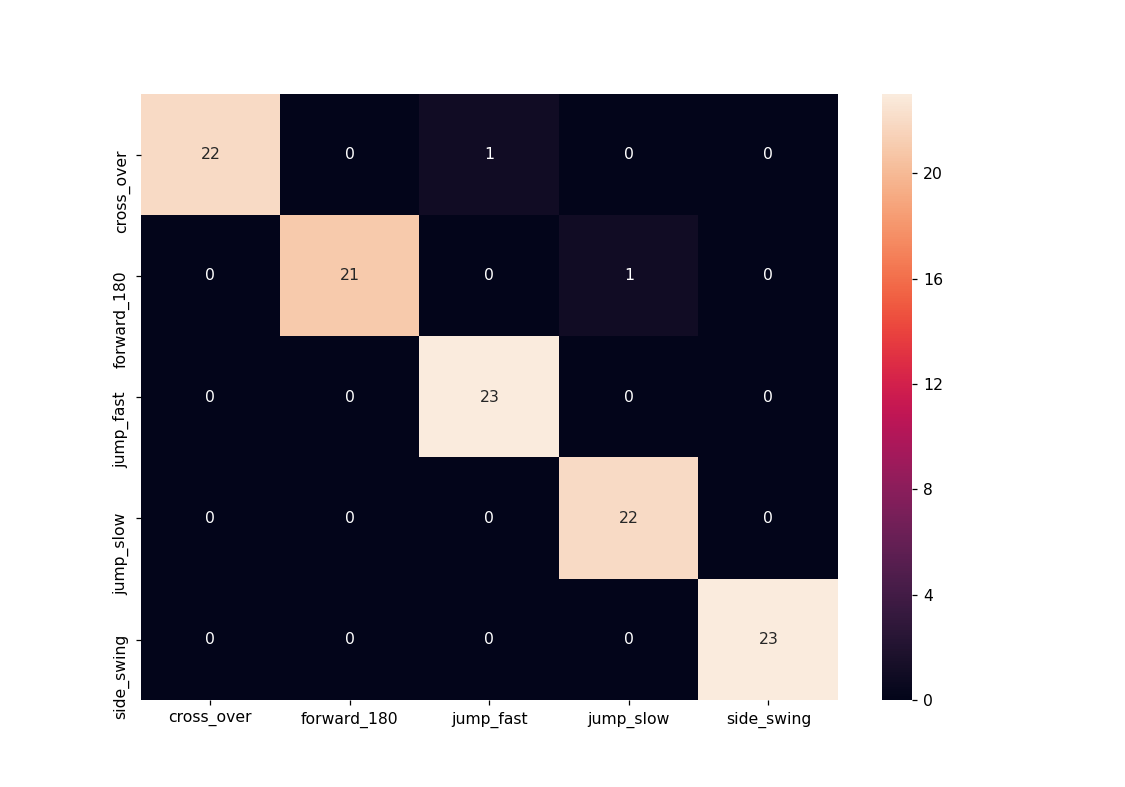

[0.05629364422942817, 0.9823009]


In [46]:
print(y_test_1.shape, y_pred.shape)
mat = confusion_matrix(y_test_1, y_pred)
results = model.evaluate(X_test, y_test)
print('test loss, test acc:', results)
heatmap(mat, label)
print(results)

## save model

In [47]:
model.save('rope_skipping_simple_cnn') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: rope_skipping_simple_cnn\assets


In [48]:
converter = tf.lite.TFLiteConverter.from_saved_model("rope_skipping_simple_cnn")
tflite_model = converter.convert()
open("converted_model2.tflite", "wb").write(tflite_model)

672040